In [1]:
#default_exp preprocess

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *

Loading imports


In [3]:
torch.cuda.set_device(3)

In [4]:
#export

def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return dcm
    
def dcm_tfm(fn):
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

def save_file(o, dest, ext, tiff):
    fname,px = o
    fn = dest/Path(fname).with_suffix(f'{ext}')
#     wins = (dicom_windows.brain, dicom_windows.subdural, dicom_windows.abdomen_soft)
    wins = [(80,40),(80,200),(40,380)] # appian windows
    if tiff: px.save_tif16(fn, compress=False)
    else:    px.save_jpg(fn, wins)

def process_batch(pxs, fnames, dest, tiff, crop, resize, n_workers=4):
    ext = '.tif' if tiff else '.jpg'
    if crop or resize: pxs = TensorImage(pxs.cuda())
    if resize:
        tfm = AffineCoordTfm(size=256)
        pxs = tfm(pxs.unsqueeze(1)).squeeze()
    if crop:
        masks = pxs.mask_from_blur((80,40))
        bbs = mask2bbox(masks)
        pxs = crop_resize(pxs, bbs, 256)
    if crop or resize: pxs = pxs.cpu().squeeze()
    parallel(save_file, zip(fnames, pxs), n_workers=n_workers, progress=False, dest=dest, ext=ext, tiff=tiff)
    

In [5]:
#export
def filename(o): return os.path.splitext(os.path.basename(o))[0]

In [6]:
#export
def process_dataset(resize=False, test=False, tiff=False, crop=False, trial=False, bs=128, n_workers=8):
    df = meta.df_tst if test else meta.df_comb
    path_dcm = path_tst if test else path_trn
    fns = [path_dcm/f'{filename(o)}.dcm' for o in df.fname.values]
    dest_fn = ('tst_'  if test else
               'crop_' if crop else
               'nocrop_')
    dest_fn += 'tif' if tiff else 'jpg'
    if resize: dest_fn += '256'
    dest = path/dest_fn
    dest.mkdir(exist_ok=True)
    
    fns = [x for x in fns if not (dest/x.name).exists()]

    dsrc = DataSource(fns, [[dcm_tfm],[os.path.basename]])
    dl = TfmdDL(dsrc, bs=bs, num_workers=1)

    for i,b in enumerate(progress_bar(dl)):
        process_batch(*b, dest=dest, tiff=tiff, crop=crop, resize=resize, n_workers=n_workers)
        if trial and i==2: break

In [7]:
#export
path_jpg = path/'nocrop_jpg'
path_jpg256 = path/'nocrop_jpg256'
path_tst_jpg = path/'nocrop_jpg'
path_tst_jpg256 = path/'nocrop_jpg256'

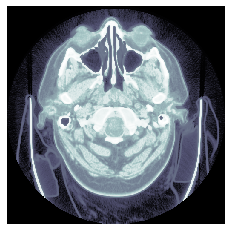

In [9]:
Meta.fns_trn[0].dcmread().show()

In [ ]:
process_dataset(resize=True)

In [8]:
process_dataset(test=True)

In [ ]:
process_dataset()

In [11]:
process_dataset(test=True, resize=True, n_workers=8)

## Calculating mean

In [7]:
#export
mean = [0.1594, 0.0766, 0.0605]
std = [0.3011, 0.2521, 0.2160]

# old
# mean = [x/255.0 for x in [ 56.2214,  62.1220, 141.9133]]
# std = [x/255.0 for x in [93.0132, 77.8876, 50.8730]]


## Creating a script

To Run this script:
`python -m rsna_retro.preprocess.preprocess_script `

In [ ]:
#export
@call_parse
def preprocess_script(
    resize:Param("Resize to 256px"   , bool)=False,
    test  :Param("Process test set"  , bool)=False,
    tiff  :Param("Save TIFF format"  , bool)=False,
    crop  :Param("Crop to brain area", bool)=False,
    trial :Param("Just do 2 batches" , bool)=False,
    bs    :Param("Batch size"        , int)=256,
    n_workers:Param("Number of workers", int)=8,
):
    print('resize,test,tiff,crop,trial,bs,n_workers')
    print(resize,test,tiff,crop,trial,bs,n_workers)
    process_dataset(resize,test,tiff,crop,trial,bs,n_workers)

## Export

In [9]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 03_train3d.ipynb.
Converted 03_train3d_01_train3d.ipynb.
Converted 03_train3d_02_train_head.ipynb.
Converted 04_trainSeq_01_lstm.ipynb.
Converted 04_trainSeq_02_transformer.ipynb.
Converted 05_train_adjacent.ipynb.
